In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

ROOT_DIR = Path().resolve(strict=True).parent
DATA_DIR = f"{ROOT_DIR}/data/"

columns_to_skip = [
        "Shares (Basic)",
    "Sector",
    "Shares (Diluted)"
    ]

df = pd.read_csv(f"{DATA_DIR}/interim/more_fts.csv", index_col=0, usecols=lambda x: x not in columns_to_skip)

In [2]:
df.loc[df['Ticker'] == df['Ticker'].shift(periods=-1), 'next_year_revenue'] = df['Revenue'].shift(periods=-1)

train_df = df[(df["Fiscal Year"] <= 2017) & (df["Fiscal Year"] >= 2010)].dropna(subset = ['next_year_revenue'])
train_df = train_df.dropna(subset = ['next_year_revenue'])
test_df = df[(df["Fiscal Year"] <= 2019) & (df["Fiscal Year"] >= 2018)]
test_df = test_df.dropna(subset = ['next_year_revenue'])
train_df = train_df.drop(columns=["Fiscal Year", "Ticker"])
test_df = test_df.drop(columns=["Fiscal Year", "Ticker"])

y_train=train_df['next_year_revenue']
X_train=train_df.drop(['next_year_revenue'],axis=1)
y_test=test_df['next_year_revenue']
X_test=test_df.drop(['next_year_revenue'],axis=1)

In [3]:
import xgboost
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lars, Ridge, SGDRegressor, TheilSenRegressor, HuberRegressor, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR, NuSVR, LinearSVR

In [4]:
xg_classifier = xgboost.XGBRegressor()
theil_sen_reg = TheilSenRegressor(random_state=0)
lars_reg = Lars(n_nonzero_coefs=1)
sdg_reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
ridge_reg = Ridge(alpha=1.0)
random_forrest_reg = RandomForestRegressor(max_depth=100, random_state=0)
poly_regs= PolynomialFeatures(degree= 2)
lin_reg =LinearRegression()
dec_tre_reg = DecisionTreeRegressor(max_depth=100)
svr_reg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
huber_reg = HuberRegressor()


linearsvr_reg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
lasso_reg = Lasso()
nusvr_reg = make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1))
bagging_reg = BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0)

In [5]:
random_forrest_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
sdg_reg.fit(X_train, y_train)
lars_reg.fit(X_train, y_train)
theil_sen_reg.fit(X_train, y_train)
xg_classifier.fit(X_train, y_train)
dec_tre_reg.fit(X_train, y_train)
lin_reg_poly = lin_reg.fit(poly_regs.fit_transform(X_train), y_train)
lin_reg.fit(X_train, y_train)
svr_reg.fit(X_train, y_train)
huber_reg.fit(X_train, y_train)
linearsvr_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
nusvr_reg.fit(X_train, y_train)
bagging_reg.fit(X_train, y_train)

/home/lucas/Dev/earnings_predictions/epvenv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.10217e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/lucas/Dev/earnings_predictions/epvenv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/home/lucas/Dev/earnings_predictions/epv

BaggingRegressor(base_estimator=SVR(), random_state=0)

In [6]:
xg_pred = xg_classifier.predict(X_test)
dec_tre_reg_pred = dec_tre_reg.predict(X_test)
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_poly_pred = lin_reg_poly.predict(X_test)
random_forrest_reg_pred = random_forrest_reg.predict(X_test)
ridge_reg_pred = ridge_reg.predict(X_test)
sdg_reg_pred = sdg_reg.predict(X_test)
lars_reg_pred = lars_reg.predict(X_test)
svr_reg_pred = svr_reg.predict(X_test)
theil_sen_reg_pred = theil_sen_reg.predict(X_test)
huber_reg_pred = huber_reg.predict(X_test)
linearsvr_reg_pred = linearsvr_reg.predict(X_test)
lasso_reg_pred = lasso_reg.predict(X_test)
nusvr_reg_pred = nusvr_reg.predict(X_test)
bagging_reg_pred = bagging_reg.predict(X_test)

In [7]:
from src.models.predict_model import calculate_bests

In [8]:
results_dict = {
    "xg_classifier": {"model":xg_classifier,"pred": xg_pred,},
    "dec_tre_reg": {"model":dec_tre_reg,"pred": dec_tre_reg_pred,},
    "lin_reg": {"model":lin_reg,"pred": lin_reg_pred,},
    "lin_reg_poly": {"model":lin_reg_poly,"pred": lin_reg_poly_pred,},
    "random_forrest_reg": {"model":random_forrest_reg,"pred": random_forrest_reg_pred,},
    "ridge_reg": {"model":ridge_reg,"pred": ridge_reg_pred,},
    "sdg_reg": {"model":sdg_reg,"pred": sdg_reg_pred,},
    "lars_reg": {"model":lars_reg,"pred": lars_reg_pred,},
    "svr_reg": {"model":svr_reg,"pred": svr_reg_pred,},
    "theil_sen_reg": {"model":theil_sen_reg,"pred": theil_sen_reg_pred,},
    "huber_reg": {"model":huber_reg,"pred": huber_reg_pred,},
    "linearsvr_reg": {"model":linearsvr_reg,"pred": linearsvr_reg_pred,},
    "lasso_reg": {"model":lasso_reg,"pred": lasso_reg_pred,},
    "nusvr_reg": {"model":nusvr_reg,"pred": nusvr_reg_pred,},
    "bagging_reg": {"model":bagging_reg,"pred": bagging_reg_pred,},
}

In [9]:
results_dict = calculate_bests(results_dict, X_train, y_train, y_test)

In [10]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [11]:

pp.pprint(results_dict)

{   'bagging_reg': {   'average_position': 12,
                       'mean_absolute_error': 43.4467115879162,
                       'mean_absolute_error_position': 13,
                       'mean_squared_error': 45280.777659802,
                       'mean_squared_error_position': 12,
                       'r2_score': 0.2367820662353204,
                       'r2_score_position': 12,
                       'score': 0.25264328259989877,
                       'score_position': 11},
    'dec_tre_reg': {   'average_position': 7.5,
                       'mean_absolute_error': 8.93116840113529,
                       'mean_absolute_error_position': 9,
                       'mean_squared_error': 1020.937813292337,
                       'mean_squared_error_position': 10,
                       'r2_score': 0.9827918580767896,
                       'r2_score_position': 10,
                       'score': 1.0,
                       'score_position': 1},
    'huber_reg': {   'average_p

In [12]:
from src.visualization.visualize import plot_charts

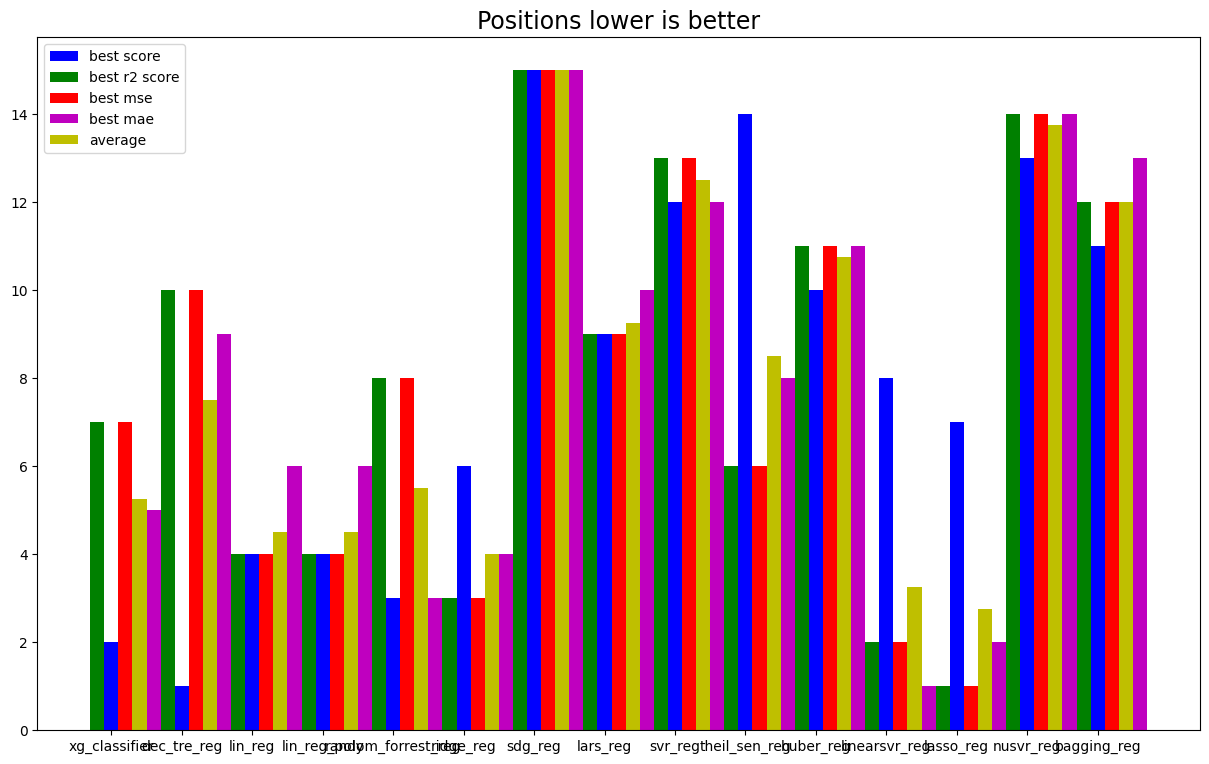

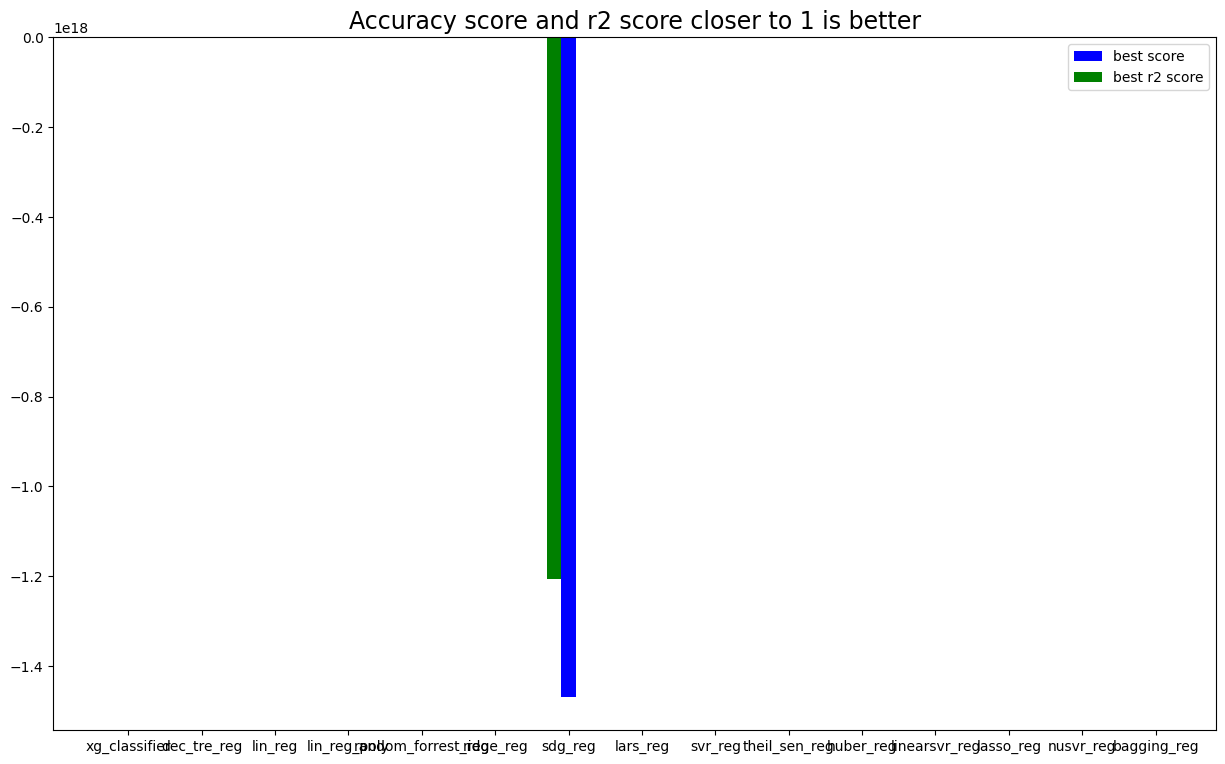

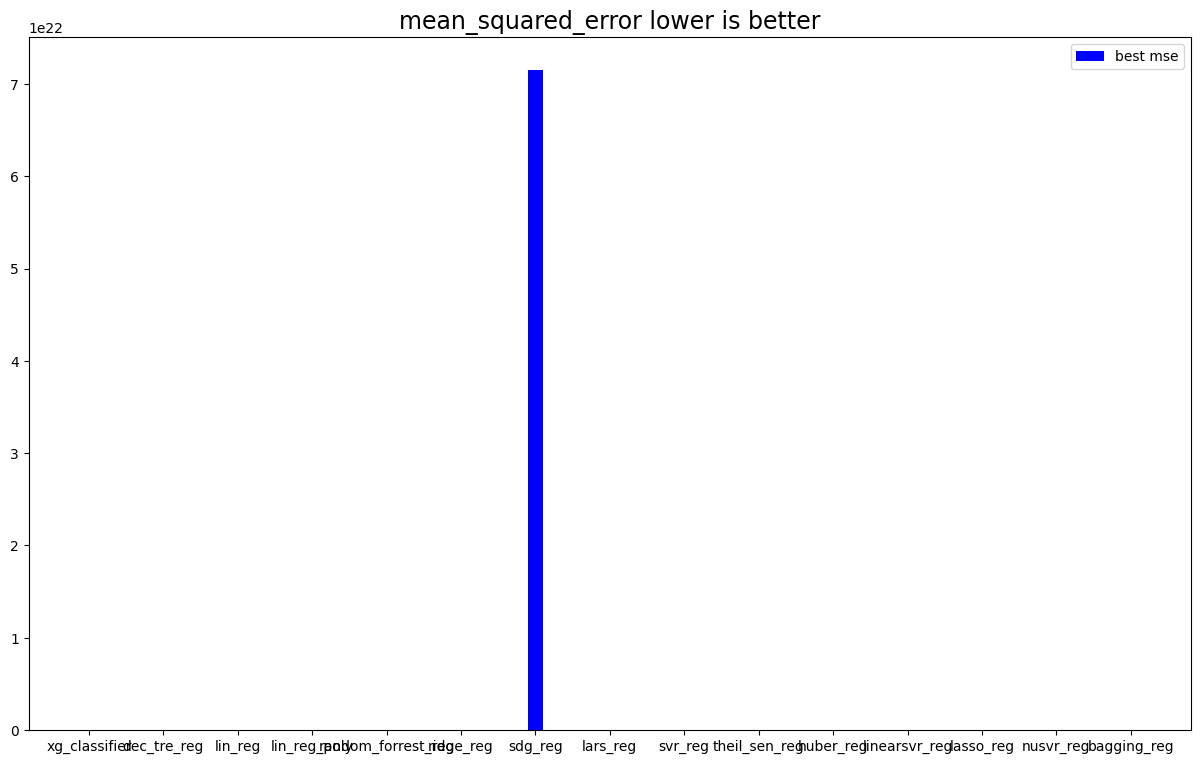

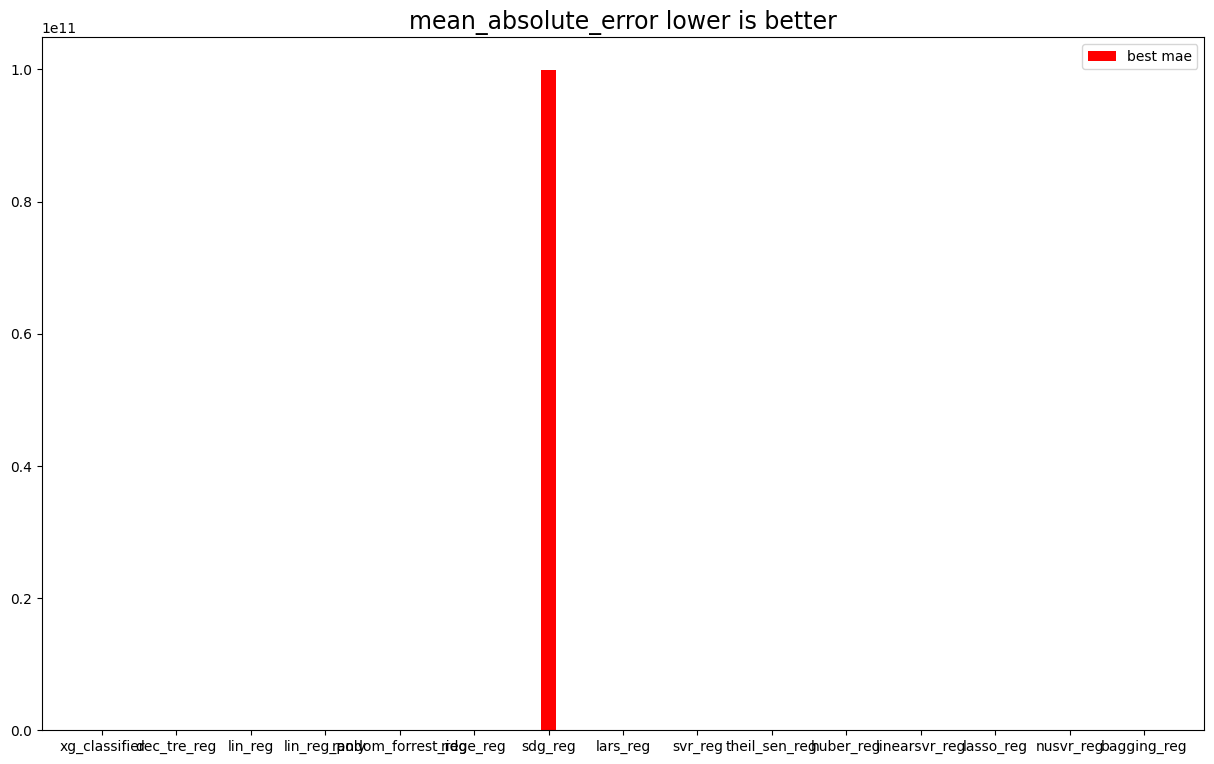

In [13]:
plot_charts(results_dict=results_dict)

In [14]:
results_dict.pop("sdg_reg")


{'score': -1.46902293132748e+18,
 'r2_score': -1.2049674546732467e+18,
 'mean_squared_error': 7.148923130412145e+22,
 'mean_absolute_error': 99889628549.03131,
 'score_position': 15,
 'r2_score_position': 15,
 'mean_squared_error_position': 15,
 'mean_absolute_error_position': 15,
 'average_position': 15}

In [15]:
results_dict.pop("theil_sen_reg")


{'score': -269.96300957289725,
 'r2_score': 0.9903487123130613,
 'mean_squared_error': 572.5989819544758,
 'mean_absolute_error': 6.536364614571881,
 'score_position': 14,
 'r2_score_position': 6,
 'mean_squared_error_position': 6,
 'mean_absolute_error_position': 8,
 'average_position': 8.5}

In [16]:
results_dict.pop("svr_reg")

{'score': 0.20424574330079326,
 'r2_score': 0.18233579312926362,
 'mean_squared_error': 48511.00781799474,
 'mean_absolute_error': 40.69541697329389,
 'score_position': 12,
 'r2_score_position': 13,
 'mean_squared_error_position': 13,
 'mean_absolute_error_position': 12,
 'average_position': 12.5}

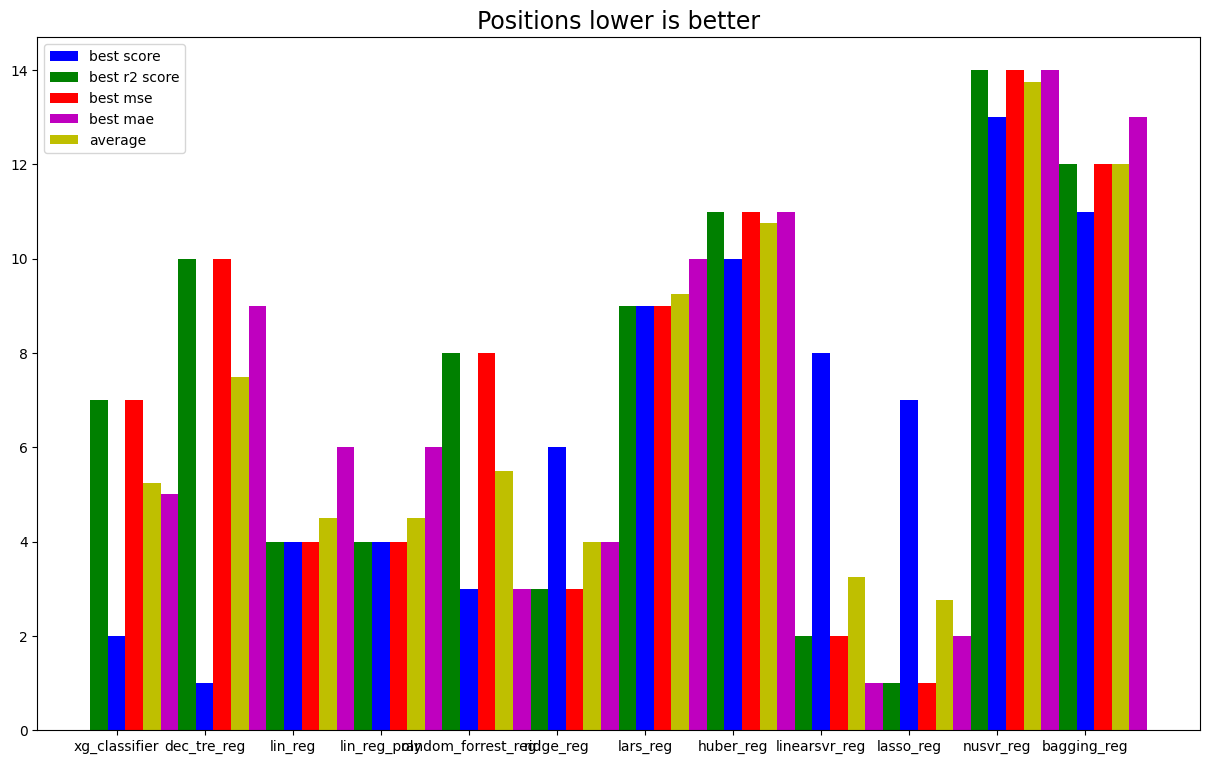

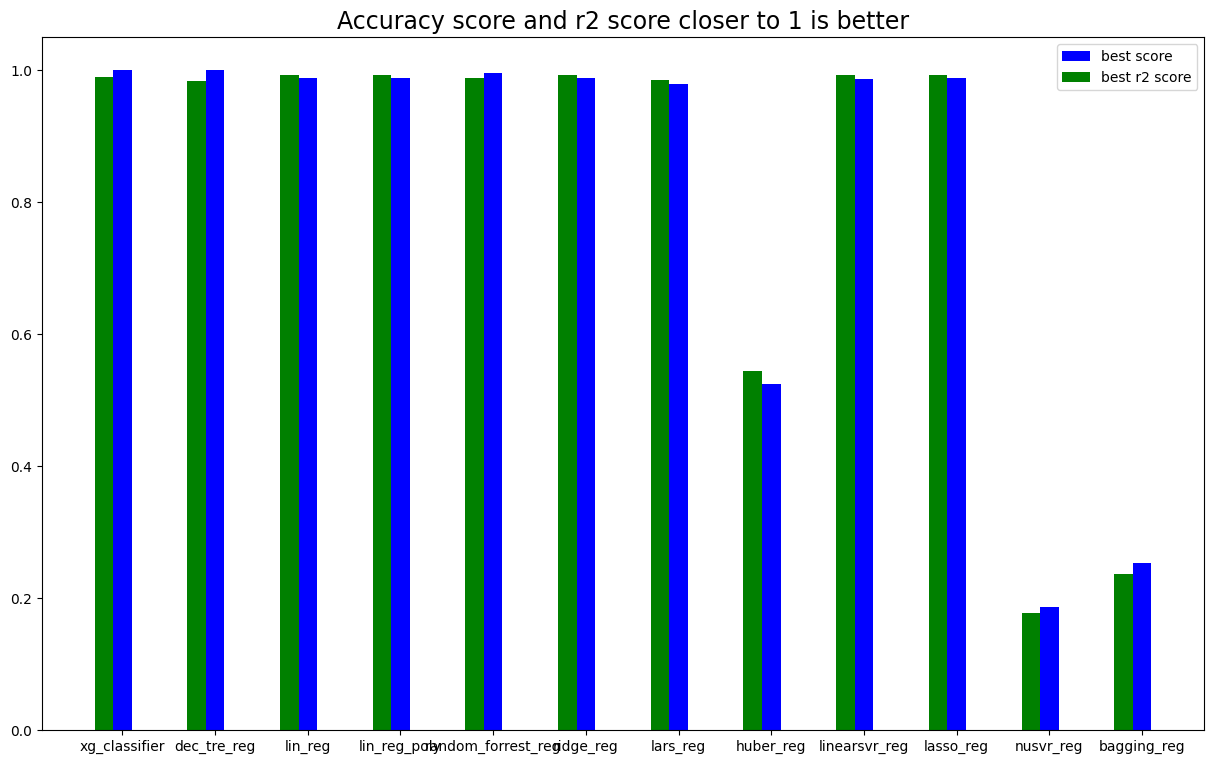

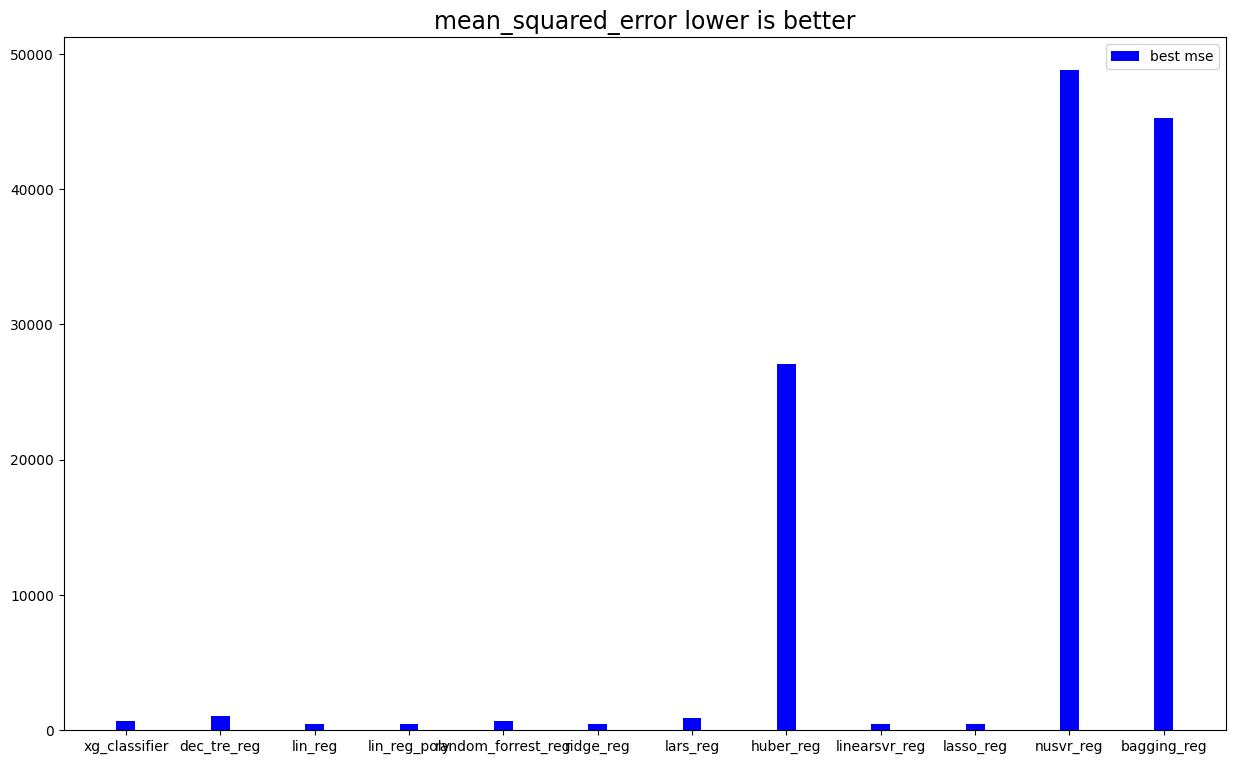

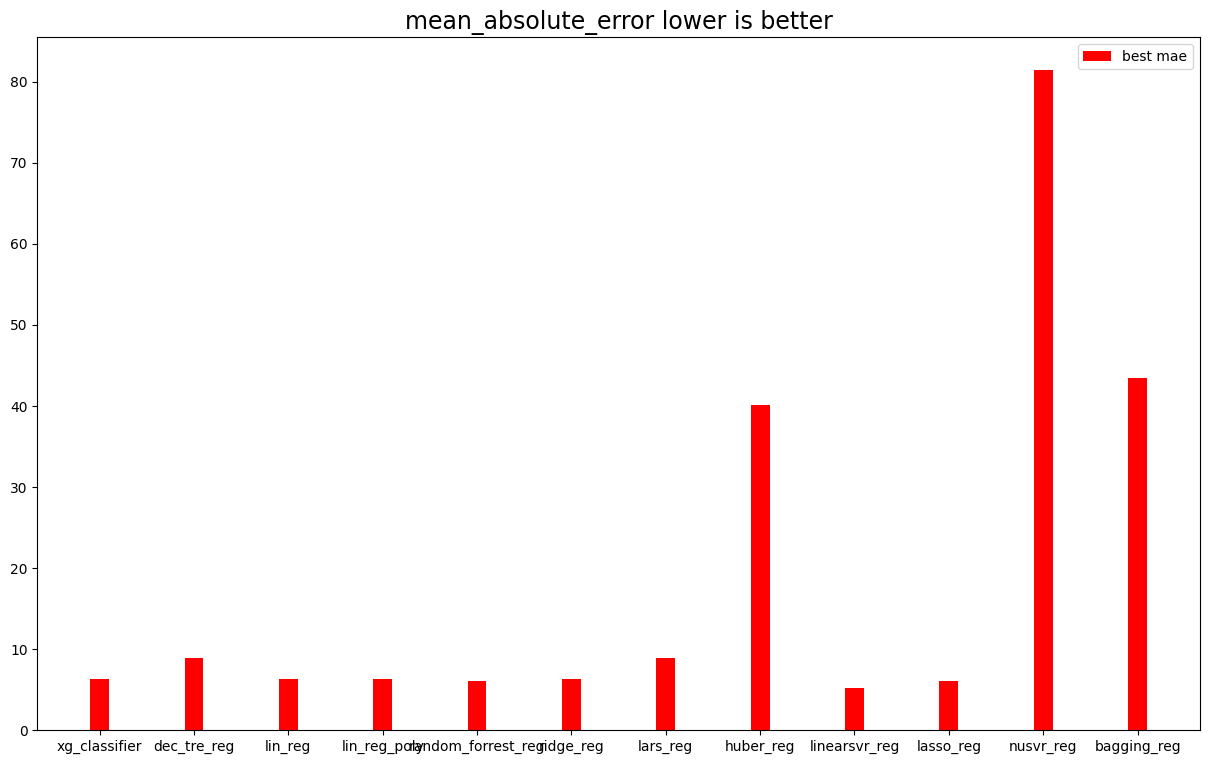

In [17]:
plot_charts(results_dict=results_dict)
# Lower score is better

In [20]:
results_dict.pop("huber_reg")

{'score': 0.5244896311023379,
 'r2_score': 0.5440653764600791,
 'mean_squared_error': 27050.038268993438,
 'mean_absolute_error': 40.129715608709155,
 'score_position': 10,
 'r2_score_position': 11,
 'mean_squared_error_position': 11,
 'mean_absolute_error_position': 11,
 'average_position': 10.75}

In [21]:
results_dict.pop("nusvr_reg")

{'score': 0.1859376062098157,
 'r2_score': 0.17755958171297015,
 'mean_squared_error': 48794.37454410219,
 'mean_absolute_error': 81.40165493909748,
 'score_position': 13,
 'r2_score_position': 14,
 'mean_squared_error_position': 14,
 'mean_absolute_error_position': 14,
 'average_position': 13.75}

In [22]:
results_dict.pop("bagging_reg")

{'score': 0.25264328259989877,
 'r2_score': 0.2367820662353204,
 'mean_squared_error': 45280.777659802,
 'mean_absolute_error': 43.4467115879162,
 'score_position': 11,
 'r2_score_position': 12,
 'mean_squared_error_position': 12,
 'mean_absolute_error_position': 13,
 'average_position': 12}

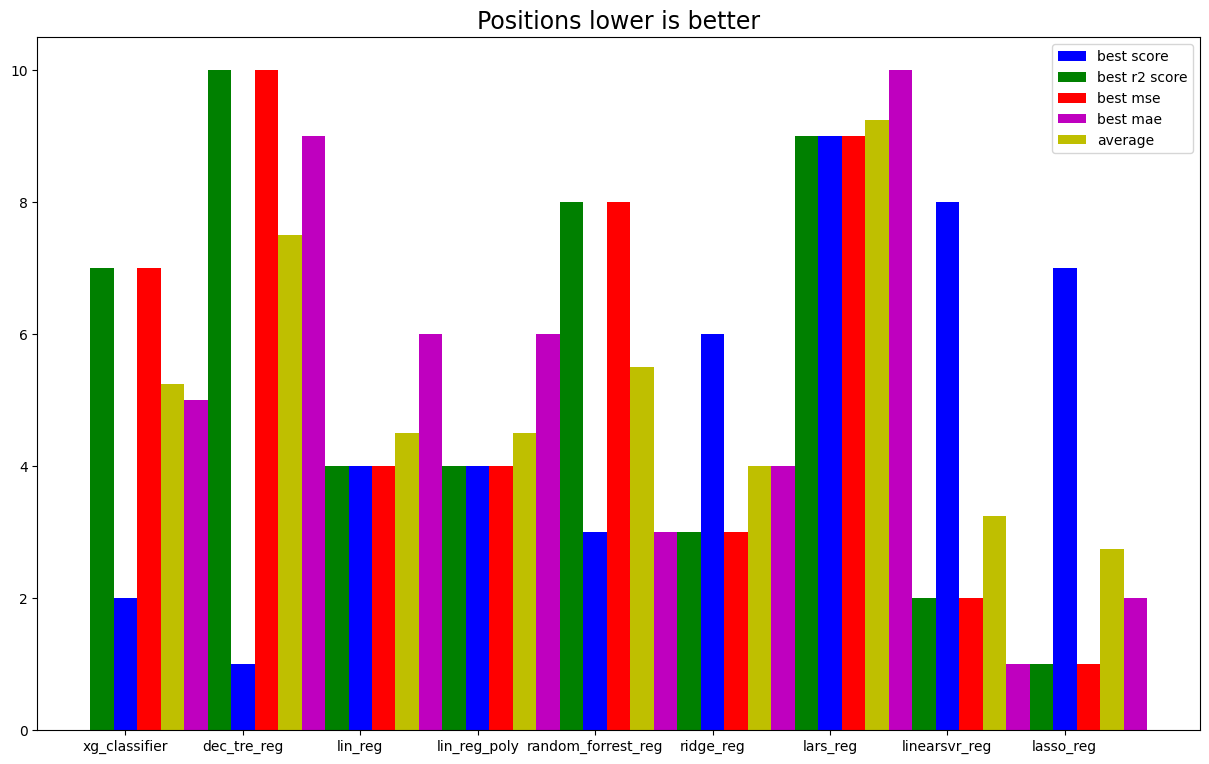

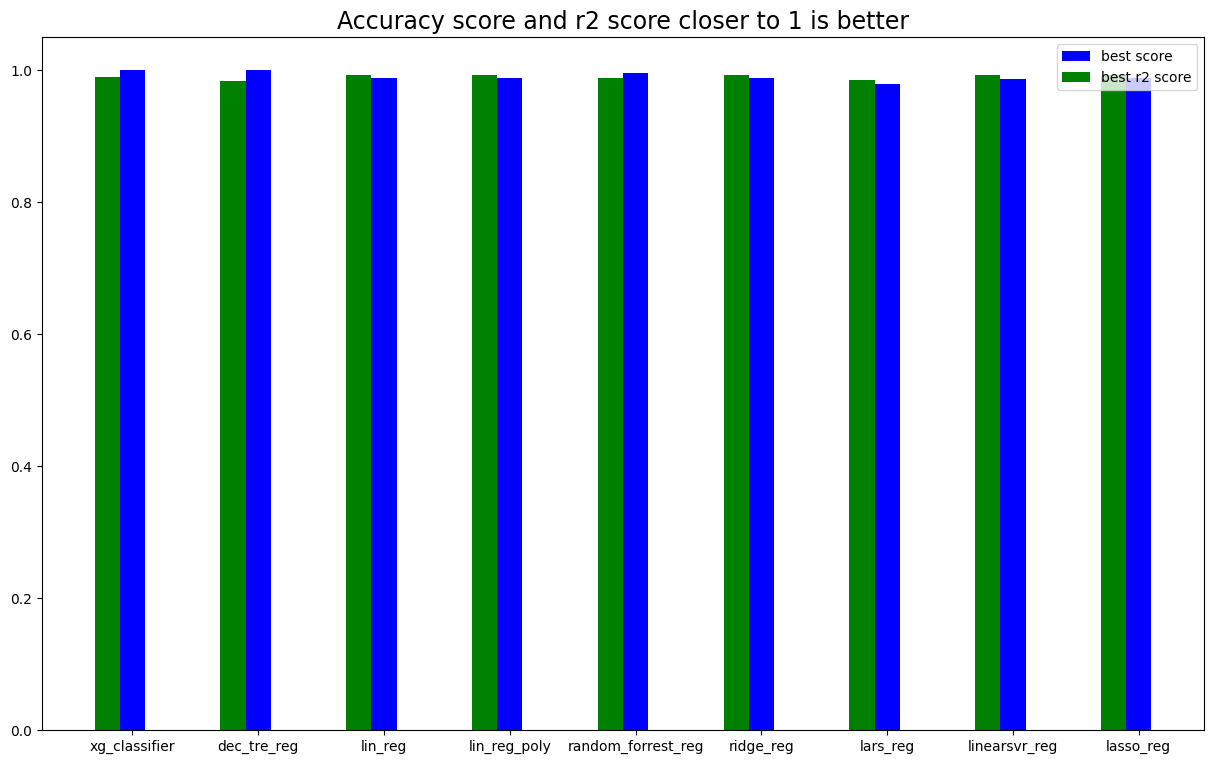

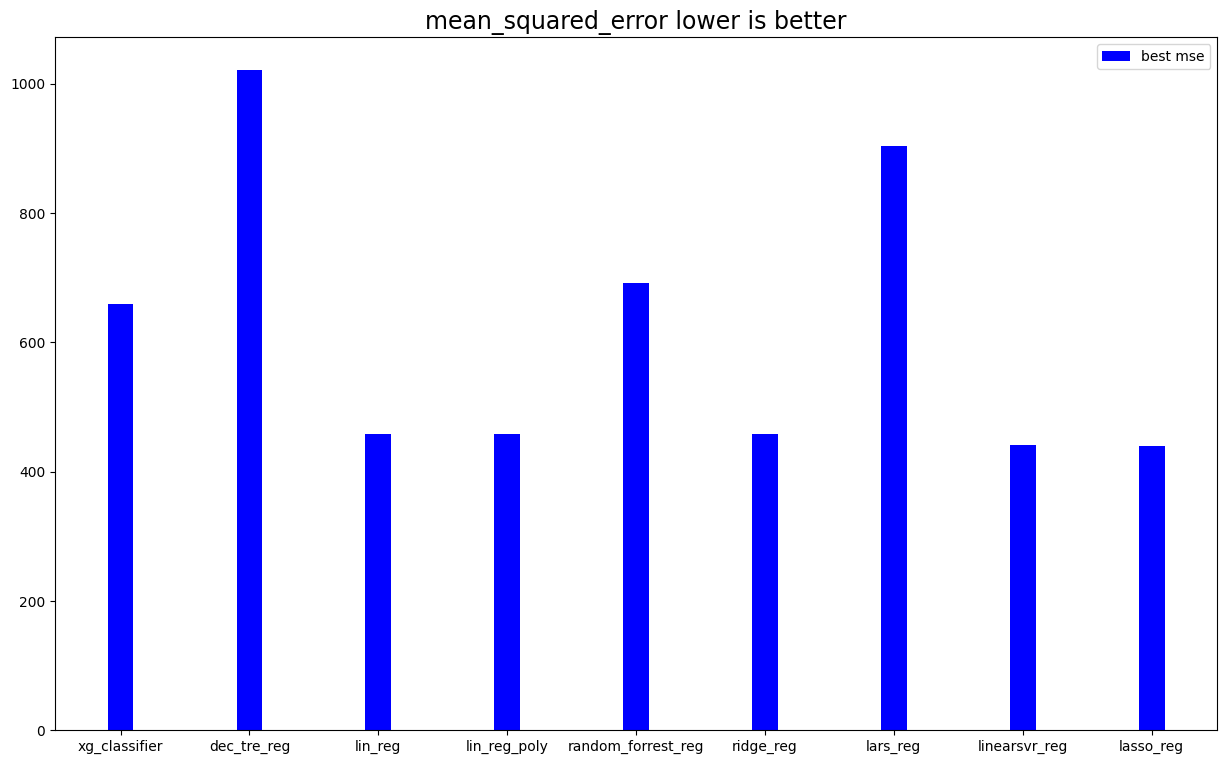

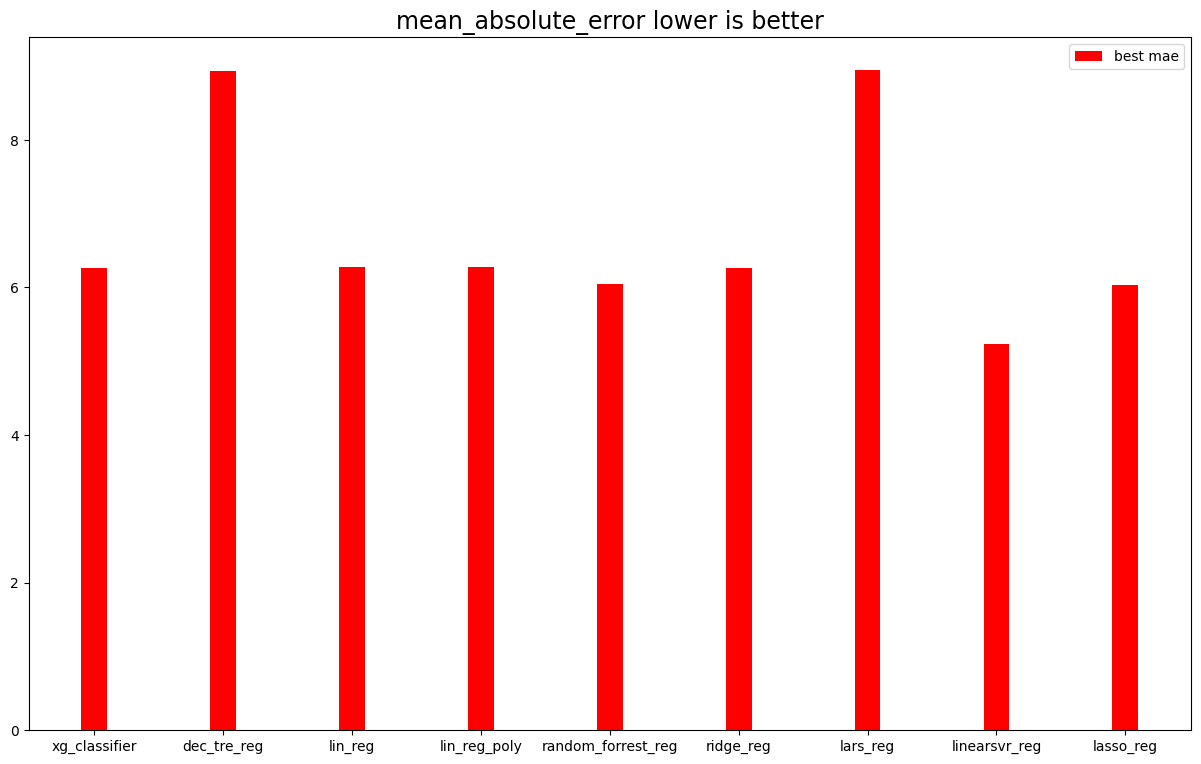

In [23]:
plot_charts(results_dict=results_dict)

In [25]:
results_dict.keys()

dict_keys(['xg_classifier', 'dec_tre_reg', 'lin_reg', 'lin_reg_poly', 'random_forrest_reg', 'ridge_reg', 'lars_reg', 'linearsvr_reg', 'lasso_reg'])

In [18]:
# xg_classifier = xgboost.XGBRegressor()
# lars_reg = Lars(n_nonzero_coefs=1)
# ridge_reg = Ridge(alpha=1.0)
# random_forrest_reg = RandomForestRegressor(max_depth=2, random_state=0)
# poly_regs= PolynomialFeatures(degree= 2)
# lin_reg =LinearRegression()

In [26]:
import pickle

In [30]:
MODELS_DIR = f"{ROOT_DIR}/models/notebook-5.0/"

pickle.dump(random_forrest_reg, open(f"{MODELS_DIR}random_forrest_reg.pkl", "wb"))
pickle.dump(ridge_reg, open(f"{MODELS_DIR}ridge_reg.pkl", "wb"))
pickle.dump(lars_reg, open(f"{MODELS_DIR}lars_reg.pkl", "wb"))
pickle.dump(xg_classifier, open(f"{MODELS_DIR}xg_classifier.pkl", "wb"))
pickle.dump(dec_tre_reg, open(f"{MODELS_DIR}dec_tre_reg.pkl", "wb"))
pickle.dump(lin_reg_poly, open(f"{MODELS_DIR}lin_reg_poly.pkl", "wb"))
pickle.dump(lin_reg, open(f"{MODELS_DIR}lin_reg.pkl", "wb"))
pickle.dump(linearsvr_reg, open(f"{MODELS_DIR}linearsvr_reg.pkl", "wb"))
pickle.dump(lasso_reg, open(f"{MODELS_DIR}lasso_reg.pkl", "wb"))